In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

#from gensim.models.coherencemodel import CoherenceModel

import TextCleaning

In [24]:
# pull in raw abstracts

raw_df=pd.read_csv('../../data/original/raw_abstracts.csv',engine='python')

# remove null abstracts and duplicates

olddf = TextCleaning.remove_nulls(raw_df, "ABSTRACT")
olddf = TextCleaning.remove_duplicates(df)

olddf.reset_index(inplace = True)
olddf.rename(columns={'index':'original index'}, inplace=True)

3 nulls in  ABSTRACT . These rows removed.
0 duplicate abstracts removed
0 project ID duplicates - not removed


In [55]:
new.head()

,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,89996.0,"This is a project to explore Game-based, Metap...",2008.0,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,...,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008.0,1999467.0,NaN
1,89997.0,Institution: Franklin Institute Science Museum...,2008.0,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,...,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008.0,1799699.0,NaN
2,89998.0,Through programs (including small group conver...,2008.0,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,...,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008.0,1505858.0,NaN
3,89999.0,In partnership with the American Chemical Soci...,2008.0,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,...,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008.0,51000.0,NaN
4,90000.0,Amphibian populations around the world are exp...,2008.0,Amphibia; Central America; Communicable Diseas...,COLLABORATIVE RESEARCH: EVOLUTION OF AMPHIBIAN...,NSF,NSF,NaN,0815315,10/1/2008,...,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.074,2008.0,370996.0,NaN


In [54]:
new = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')
new = new.rename(columns={'FY.x': 'FY'})

df = TextCleaning.remove_nulls(new, "ABSTRACT")
df = TextCleaning.remove_duplicates(df)

df.reset_index(inplace = True)
df.rename(columns={'index':'original index'}, inplace=True)

42380 nulls in  ABSTRACT . These rows removed.
79184 duplicate abstracts removed
0 project ID duplicates - not removed


In [48]:
new.ABSTRACT.value_counts

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        848
No abstract provided                                                                                                                                                                                                                                   

In [60]:
new[new.ABSTRACT == "The Vaccine and Treatment Evaluation Units (VTEUs) are a consortium of individual contracts within academic centers and organizations that provide a ready resource for the design and conduct of clinical trials to evaluate promising vaccines and treatments for infectious disease. Investigations of novel product delivery systems and routes of delivery may also be conducted. In general, products will be evaluated in normal healthy populations; however, access to special populations is also available."][['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER']]#.sort_values()

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER
411955,2011.0,250000.0,"BERNSTEIN, DAVID"
412078,2011.0,500000.0,"MULLIGAN, MARK JOSEPH"
412109,2011.0,2000000.0,"WINOKUR, PATRICIA"
412140,2011.0,250000.0,"MULLIGAN, MARK JOSEPH"
412342,2011.0,500000.0,"WINOKUR, PATRICIA"
...,...,...,...
1086502,2019.0,721834.0,"MULLIGAN, MARK"
1090403,2019.0,405891.0,"HOFT, DANIEL"
1094195,2019.0,112851.0,"KOTLOFF, KAREN L."
1099132,2019.0,442431.0,"SZTEIN, MARCELO"


In [52]:
df.columns

Index(['PROJECT_ID', 'ABSTRACT', 'FY.x', 'PROJECT_TERMS', 'PROJECT_TITLE',
       'DEPARTMENT', 'AGENCY', 'IC_CENTER', 'PROJECT_NUMBER',
       'PROJECT_START_DATE', 'PROJECT_END_DATE', 'CONTACT_PI_PROJECT_LEADER',
       'OTHER_PIS', 'CONGRESSIONAL_DISTRICT', 'DUNS_NUMBER',
       'ORGANIZATION_NAME', 'ORGANIZATION_CITY', 'ORGANIZATION_STATE',
       'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY', 'BUDGET_START_DATE',
       'BUDGET_END_DATE', 'CFDA_CODE', 'FY.y', 'FY_TOTAL_COST',
       'FY_TOTAL_COST_SUB_PROJECTS'],
      dtype='object')

In [17]:
olddf.columns

Index(['original index', 'PROJECT_ID', 'ABSTRACT', 'FY', 'FIRST_CHAR',
       'LAST_CHAR', 'DEPARTMENT', 'AGENCY', 'IC_CENTER', 'PROJECT_NUMBER',
       'PROJECT_TITLE', 'PROJECT_TERMS', 'CONTACT_PI_PROJECT_LEADER',
       'OTHER_PIS', 'ORGANIZATION_NAME', 'CFDA_CODE', 'FY_TOTAL_COST'],
      dtype='object')

In [28]:
len(df)

1113757

In [29]:
len(olddf)

550074

In [20]:
df.head()

,PROJECT_ID,ABSTRACT,FY.x,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,89996.0,"This is a project to explore Game-based, Metap...",2008.0,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,...,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008.0,1999467.0,NaN
1,89997.0,Institution: Franklin Institute Science Museum...,2008.0,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,...,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008.0,1799699.0,NaN
2,89998.0,Through programs (including small group conver...,2008.0,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,...,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008.0,1505858.0,NaN
3,89999.0,In partnership with the American Chemical Soci...,2008.0,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,...,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008.0,51000.0,NaN
4,90000.0,Amphibian populations around the world are exp...,2008.0,Amphibia; Central America; Communicable Diseas...,COLLABORATIVE RESEARCH: EVOLUTION OF AMPHIBIAN...,NSF,NSF,NaN,0815315,10/1/2008,...,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.074,2008.0,370996.0,NaN


In [27]:
(df['FY.x'] == df['FY.y']).sum()

1113728

In [30]:
(df['FY.x'] != df['FY.y']).sum()

29

In [44]:
df['FY.x'].value_counts()

2009.0    114017
2010.0    105937
2008.0     99866
2018.0     95757
2011.0     92893
2016.0     89462
2015.0     88454
2017.0     87906
2013.0     86724
2014.0     86524
2012.0     86338
2019.0     79879
Name: FY.x, dtype: int64

In [45]:
df['FY.y'].value_counts()

2009.0      114013
2010.0      105929
2008.0       99860
2018.0       95755
2011.0       92892
2016.0       89462
2015.0       88454
2017.0       87904
2013.0       86723
2014.0       86523
2012.0       86337
2019.0       79876
329831.0         1
20772.0          1
332527.0         1
7073.0           1
82071.0          1
599098.0         1
993326.0         1
79171.0          1
81405.0          1
320749.0         1
Name: FY.y, dtype: int64

In [43]:
df[df['FY.x'] != df['FY.y']][['FY.x','FY.y']]

,FY.x,FY.y
16282,2008.0,NaN
50636,2008.0,NaN
73128,2008.0,NaN
73784,2008.0,81405.0
73807,2008.0,329831.0
87421,2008.0,7073.0
126758,2009.0,NaN
154276,2009.0,NaN
187001,2009.0,320749.0
187618,2009.0,79171.0


In [70]:
olddf.isnull().sum()

original index                    0
original index                    0
PROJECT_ID                        0
ABSTRACT                          0
FY                                0
FIRST_CHAR                        0
LAST_CHAR                         0
DEPARTMENT                        0
AGENCY                            0
IC_CENTER                    373839
PROJECT_NUMBER                    0
PROJECT_TITLE                     0
PROJECT_TERMS                  4967
CONTACT_PI_PROJECT_LEADER        55
OTHER_PIS                    464271
ORGANIZATION_NAME               298
CFDA_CODE                     76571
FY_TOTAL_COST                124403
dtype: int64

In [69]:
df.isnull().sum()

original index                     0
PROJECT_ID                         0
ABSTRACT                           0
FY                                 0
PROJECT_TERMS                   3047
PROJECT_TITLE                      0
DEPARTMENT                         0
AGENCY                             0
IC_CENTER                     553155
PROJECT_NUMBER                     0
PROJECT_START_DATE            139195
PROJECT_END_DATE              131265
CONTACT_PI_PROJECT_LEADER         43
OTHER_PIS                     900494
CONGRESSIONAL_DISTRICT         67560
DUNS_NUMBER                    11179
ORGANIZATION_NAME               1379
ORGANIZATION_CITY               5274
ORGANIZATION_STATE             11303
ORGANIZATION_ZIP               45466
ORGANIZATION_COUNTRY            5069
BUDGET_START_DATE             586450
BUDGET_END_DATE               586501
CFDA_CODE                     175908
FY.y                              18
FY_TOTAL_COST                 257232
FY_TOTAL_COST_SUB_PROJECTS    971978
d

In [62]:
df.IC_CENTER.value_counts()

NCI        74930
NIAID      50267
NIGMS      48037
NHLBI      42223
NIDDK      33231
NINDS      31057
NIA        24787
NIMH       23247
NICHD      22934
NIDA       16867
NEI        11856
NIEHS      11518
NIAMS      11023
VA          9545
NIAAA       8442
NIDCD       7969
NIBIB       6611
NIDCR       6131
NIMHD       4553
OD          4203
NHGRI       4100
FDA         3254
ARS         3196
AHRQ        3194
NINR        2764
NCATS       2763
FIC         2043
NCER        1640
NLM         1588
NCCIH       1582
NIOSH       1189
CLC          977
NCCDPHP      693
NCCAM        605
NCSER        493
NCBDD        355
NCIPC        345
ACF          234
NCIRD        209
COGH         195
NCHHSTP      192
CDC          168
CIT           88
NCEH          62
ATSDR         37
COTPER         9
NCHS           8
CID            2
OGDP           1
WH             1
Name: IC_CENTER, dtype: int64

In [63]:
year = df.FY.value_counts()
year

2009.0    102485
2010.0     98724
2008.0     94845
2011.0     88166
2018.0     84924
2016.0     83087
2015.0     82061
2013.0     81809
2012.0     81390
2017.0     81351
2014.0     80685
2019.0     75046
Name: FY, dtype: int64

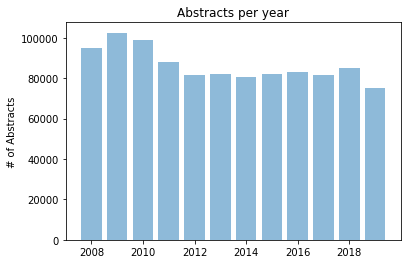

In [64]:
plt.bar(year.index, year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year')

plt.show()

In [67]:
oldyear = olddf.FY.value_counts()
oldyear

2008    94845
2012    64056
2009    53412
2013    53345
2010    46348
2014    43325
2011    42760
2015    42252
2016    39679
2018    35441
2017    34611
Name: FY, dtype: int64

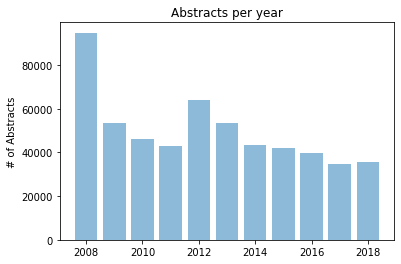

In [68]:
plt.bar(oldyear.index, oldyear, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year')

plt.show()

### NAs per year

In [25]:
nans = df.isnull()
nans = nans.drop('FY', axis=1)
nans['FY'] = df['FY']

In [35]:
nans = nans.groupby('FY').sum()
nans

,original index,PROJECT_ID,ABSTRACT,FIRST_CHAR,LAST_CHAR,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_TITLE,PROJECT_TERMS,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,ORGANIZATION_NAME,CFDA_CODE,FY_TOTAL_COST
FY,,,,,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94845.0,0.0,0.0,3047.0,5.0,88548.0,53.0,14383.0,21987.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53412.0,0.0,0.0,1514.0,4.0,44645.0,14.0,6313.0,9740.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46348.0,0.0,0.0,0.0,2.0,38250.0,62.0,6366.0,8953.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42760.0,0.0,0.0,0.0,12.0,35742.0,2.0,5729.0,10709.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14726.0,0.0,0.0,0.0,4.0,58519.0,11.0,6227.0,5180.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53345.0,0.0,0.0,0.0,14.0,44241.0,38.0,7291.0,6913.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14640.0,0.0,0.0,0.0,5.0,35227.0,24.0,7553.0,43292.0
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16067.0,0.0,0.0,0.0,5.0,34265.0,44.0,5929.0,5805.0
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15533.0,0.0,0.0,0.0,3.0,30863.0,10.0,5820.0,5171.0


In [63]:
totalnan = nans.sum(axis = 1)

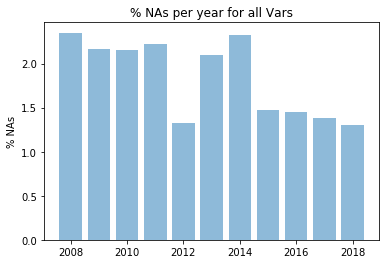

In [66]:
plt.bar(totalnan.index, totalnan/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('% NAs per year for all Vars')

plt.show()

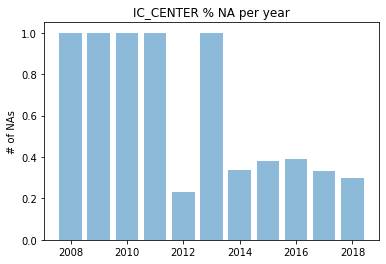

In [50]:
plt.bar(nans.index, nans.IC_CENTER/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('IC_CENTER % NA per year')

plt.show()

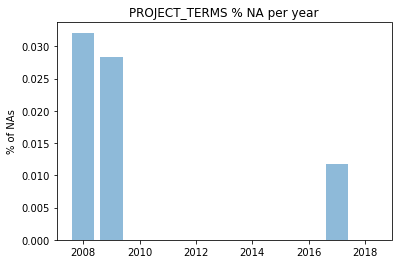

In [56]:
plt.bar(nans.index, nans.PROJECT_TERMS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('PROJECT_TERMS % NA per year')

plt.show()

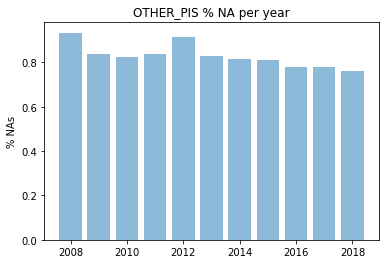

In [57]:
plt.bar(nans.index, nans.OTHER_PIS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('OTHER_PIS % NA per year')

plt.show()

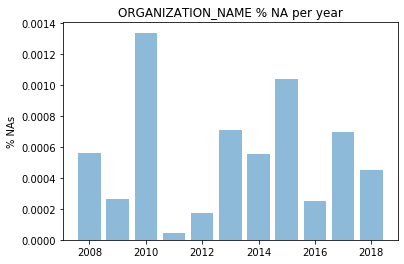

In [58]:
plt.bar(nans.index, nans.ORGANIZATION_NAME/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('ORGANIZATION_NAME % NA per year')

plt.show()

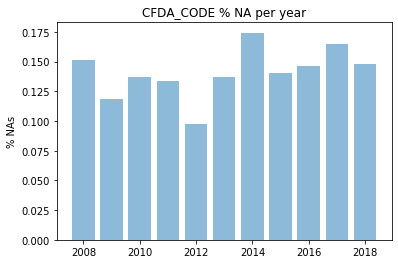

In [59]:
plt.bar(nans.index, nans.CFDA_CODE/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('CFDA_CODE % NA per year')

plt.show()

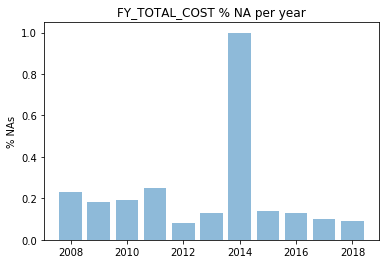

In [60]:
plt.bar(nans.index, nans.FY_TOTAL_COST/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('FY_TOTAL_COST % NA per year')

plt.show()

In [69]:
df[df.FY == 2014]

,original index,PROJECT_ID,ABSTRACT,FY,FIRST_CHAR,LAST_CHAR,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_TITLE,PROJECT_TERMS,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,ORGANIZATION_NAME,CFDA_CODE,FY_TOTAL_COST
354766,354770,589214,Objective(s): 1: Determine the nutrients in po...,2014,Objective(s): 1: Determine the nutrients in po...,.,USDA,ARS,NaN,ARS-0425868,IMPROVE NUTRITION FOR HONEY BEE COLONIES TO ST...,Bees; Chemicals; Development; Devices; Diet; E...,"HOFFMAN, GLORIA D",NaN,HONEY BEE RESEARCH INSTITUTE AND NATURE CENTER...,10.001,NaN
354767,354771,589224,Objective(s): 1. Evaluate performance and bene...,2014,Objective(s): 1. Evaluate performance and bene...,.,USDA,ARS,NaN,ARS-0426136,ALGAL-BASED WATER TREATMENT TECHNOLOGIES FOR S...,Affect; Algae; Amendment; Appearance; base; Bi...,"HALL, DAVID GOODSELL",NaN,SUBTROPICAL INSECTS AND HORTICULTURE RESEARCH,10.001,NaN
354768,354772,591601,A. Pierce s disease is especially damaging in ...,2014,A. Pierce s disease is especially damaging in ...,.,USDA,NIFA,NaN,0212205,BIOLOGICAL CONTROL OF PIERCE'S DISEASE OF GRAP...,Area; base; Biological; California; Consumptio...,"HOPKINS, DO, .",NaN,UNIVERSITY OF FLORIDA,10.203,NaN
354769,354773,593659,This project will test the overall hypothesis ...,2014,This project will test the overall hypothesis ...,.,USDA,NIFA,NaN,0217191,MOLECULAR MECHSNISMS OF INTESTINAL METAL ION T...,absorption; Address; Anemia; Anemia due to Chr...,"COLLINS, JA, F..",NaN,UNIVERSITY OF FLORIDA,10.203,NaN
354770,354774,597171,This five-year project will use social science...,2014,This five-year project will use social science...,.,USDA,NIFA,NaN,0226918,ASSESSING CLIMATE INFORMATION NEEDS AND OPPORT...,Climate; Decision Support Systems; Development...,"JONES, J.",NaN,UNIVERSITY OF FLORIDA,10.202,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398086,398090,916066,Some research has indicated that early childho...,2014,Some research has indicated that early childho...,.,ED,IES,NCER,R305A120813,LONGITUDINAL STUDY OF A SUCCESSFUL SCALING-UP ...,Development; early childhood; Effectiveness; E...,"CLEMENTS, DOUGLAS","SARAMA, JULIE; LAZER, CAROLYN",UNIVERSITY OF DENVER COLORADO SEMINARY,84.305,NaN
398087,398091,916067,National statistics point to a crisis in adole...,2014,National statistics point to a crisis in adole...,.,ED,IES,NCER,R305A120814,FOSTERING READING ENGAGEMENT IN ENGLISH-MONOLI...,Address; Adolescent; base; Books; Cognitive; c...,"TABOADA BARBER, ANA","BUEHL, MICHELLE; KIDD, K JULIE; STURTEVANT, EL...",UNIVERSITY OF MARYLAND COLLEGE PK CAMPUS,84.305,NaN
398088,398092,918185,Project AbstractThe primary objective of this ...,2014,Project AbstractThe primary objective of this ...,.,HHS,NIH,NIDDK,6R44DK085845-04,DEVELOPMENT OF AN ANTI-PSGL-1 ANTIBODY TO TREA...,Acute myocardial infarction; Allografting; all...,"ROLLINS, SCOTT A",NaN,TETHEREX PHARMACEUTICALS CORPORATION,93.847,NaN
398089,398093,918508,AbstractDiabetic retinopathy (DR) is currently...,2014,AbstractDiabetic retinopathy (DR) is currently...,.,HHS,NIH,NIDDK,7DP3DK104393-02,"OCULAR BIOMARKERS OF MICROVASCULAR, NEURAL AND...",Acute myocardial infarction; Allografting; all...,"SHAHIDI, MAHNAZ",NaN,UNIVERSITY OF SOUTHERN CALIFORNIA,93.847,NaN


In [32]:
same = df.DEPARTMENT == df.AGENCY

In [37]:
same.sum()

138925

In [38]:
len(df) - same.sum()

411149

While there are no NAN values in DEPARTMENT or AGENCY, there are mismatched between them on ~4/5 of the rows

In [32]:
repeat = olddf.FIRST_CHAR.value_counts()
repeat.head(15)

This subproject is one of many research subprojects utilizing theresources provided by a Center gran    18325
This subproject is one of many research subprojects utilizing the resourcesprovided by a Center gran     5812
This award is funded under the American Recovery and Reinvestment Act of 2009 (Public Law 111-5). Th      518
This award is funded under the American Recovery and Reinvestment Act of 2009 (Public Law 111-5).The      502
This award is funded under the American Recovery and Reinvestment Act of 2009 (Public Law 111-5).Thi      499
The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase I pr      346
The broader impact/commercial potential of this Small Business Innovation Research (SBIR) Phase II p      218
This award is funded under the American Recovery and Reinvestment Act of 2009 (Public Law 111-5).Wit      117
This award is funded under the American Recovery and Reinvestment Act of 2009 (Public Law 111-5).  T      112
The Louis 

In [67]:
df.IC_CENTER.value_counts()

NCI        25894
NIAID      19026
NIGMS      16769
NHLBI      15202
NIDDK      12396
NINDS      11561
NIA         9261
NICHD       8623
NIMH        8594
NIDA        6210
NEI         4376
NIEHS       4353
NIAMS       4053
VA          3236
NIAAA       3074
NIDCD       2878
NIBIB       2707
NIDCR       2494
OD          1976
NHGRI       1764
NIMHD       1557
AHRQ        1236
NCATS       1230
NINR        1078
NCER        1055
FDA         1024
CLC          714
FIC          700
NLM          697
NCCIH        465
NIOSH        410
NCCAM        405
NCSER        306
ACF          220
NCCDPHP      154
NCIPC        118
NCBDD         85
CIT           75
NCIRD         64
NCHHSTP       56
CDC           54
COGH          52
NCEH          16
ATSDR         10
NCHS           5
COTPER         1
WH             1
Name: IC_CENTER, dtype: int64